# Mapping Method

`1440.18.May.20`

#### Explanation of Intent

I've decided to break off a new notebook devoted to just the Mapping Method I originally tried to develop for the IEA case studies. I hit a wall when it came to boundaries with odd curves (squares, triangles, circles all worked), but this will be devoted to fixing three shortcomings:

- [ ] Take into account arclength in boundaries for no mapping error at edges
- [ ] Include 3 dimensions (should be an easy extrapolation)
- [ ] Standardize boundary definitions (points, in a clockwise circle, starting from bottom left/right/whatever
- [ ] Injective solution
- [ ] Automate corner selection
- [ ] Write a paper regarding this method

Regarding the last point, I'm sure things like this have been created on the math side with Conformal Mapping, but nothing I found was in term sof wind farm sor built for optimizations in gradient-based optimizers. A paper geared towards that will be good, I think.

Also to note the method will not work on boundaries that are not injective. I'll need to figure out how to fix or limit those cases (perhaps switch to polar?).

## Where I am so far

`1445.18.May.20`

Taking the IEA37 cs3 case as my starting point, I got pretty far with the method. The algorithm, as it stands, does the following:

1. Read in points along boundary
2. Select four "corners" that will map to the unit square
3. Spline the four "sides" between the corners
4. Map gridlines using splined sides data **<- (Where current error is)** 

Though the method works with relatively straigh-line boundaries, if there is a curve in a side, it currently fails to account for the arclength of that curve. I'll need to add that into the algorithm, but for now I'll make a sandbox and stand-alone code file that'll do what I have working so far.

## Setup Code

`1445.18.May.20`

In [1]:
#--- Mapping Method Algorithm ---#
%run "../baker_cs34_functions.py"

#-- Read in points along boundary
#- Rip the boundary coordinates from the .yaml file -#
fn = "../../startup-files/iea37-boundary-cs3.yaml"
bndryPts = getTurbAtrbtCs3YAML(fn)      # Read in the points list
coordListClsd = closeBndryList(bndryPts)    # Duplicate the first coordinate for a closed boundary

vertexList = [0, 6, 8, 9, 18]           # Hard code the vertices (though this should be done algorithmically)
numSides = 4      # The number of sides for our original coordinate system. Usually (4) to Euclidean, but could be any number)
#-- Plot our space (with splines) --#

In [2]:
#-- Select four "corners" that will map to the unit square
coordsCorners = coordListClsd[vertexList]

In [3]:
#-- Spline the four "sides" between the corners
def mmSplineBndryPts(coordBndryClsd, vertexList, bTriangle = False, numGridLines = 10):
    # numGridlines is the granularity of the re-spline. Default is 10, but less or more can be specified if desired.
    
    #- Figure out if it's a triangle or square mapping -#
    if bTriangle:
        numSides = 3
    else:
        numSides = 4

    #- Initialize outr placeholders for the splines 
    splineList = np.empty(numSides, interp1d)                  # Init. array IOT save the Splines for each "side"
    buf = np.zeros((numSides, numGridLines, 2))                # Used to initalize the recarray to zeros
    segCoordList = np.recarray([numSides, numGridLines], dtype=coordinate, buf=buf)

    #- Create the splines for each side (<numSides> many)-#
    for i in range(numSides):
        BndPts = coordBndryClsd[vertexList[i]:(vertexList[i+1]+1)]       # Extract the points for the "edge" we want
        segCoordList[i] = sliceBoundary(BndPts, numGridLines)    # Reparameterize the boundry to be defined by <numGridLines> many points
        splineList[i] = interp1d(segCoordList[i].x, segCoordList[i].y, kind='linear')   # Make the spline using NumPy's <interp1d>

    # [splineList] is a 4- or 3-element list containing the splined edges.
    # [segCoordList] is only used for plotting, is a 4- or 3-element list of x-values to be put into the splines IOT plot.  
    return splineList, segCoordList

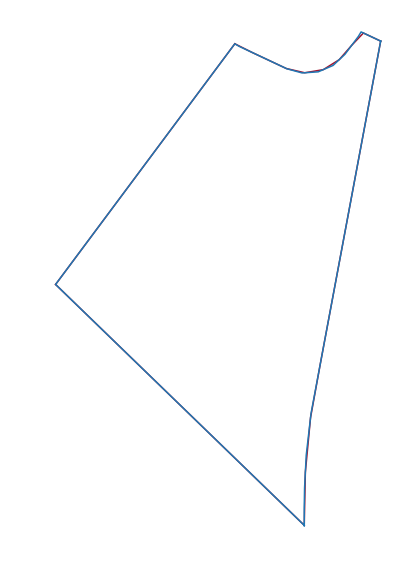

In [4]:
#- Get the splines and x-vals for plotting -#
[spList, spCoordSegList] = mmSplineBndryPts(coordListClsd, vertexList)

#- Visualization of the splines over the origianl coordinate list -#
plt.figure(figsize=(20,10))
for i in range(numSides):
    plt.hold = True
    printBndryArray(spCoordSegList[i].x, spList[i](spCoordSegList[i].x), 1)
    
printBoundary(coordListClsd)

## Mapping the Grid (where error was)

`1516.19.May.20`

### Vertical Lines

I think my problem was laready solved in the math I used to spline the boundaries. The sliceBoundary() function I wrote already moved along the boundary according to arclength, returning the coordinates in segCoordList[]. I'll use these points to calculate my gridlines. Hopefully it won't lag like before.

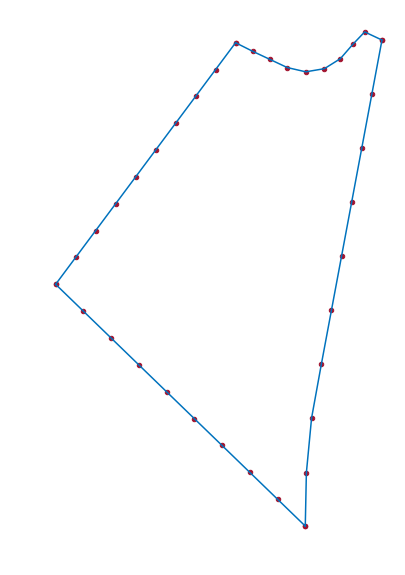

In [5]:
#-- Map gridlines using splined sides data **<- (Where current error is)** 
numGridLines = 10 # The number of divisions we'll have for the visualization

#Get values along the arclength of the side
plt.figure(figsize=(20,10))
plt.hold = True
for i in range(numSides):
    plt.hold = True
    printBndryArray(spCoordSegList[i].x, spList[i](spCoordSegList[i].x))
    
printTurbines(spCoordSegList, turbRadius=20)

`1610.19.May.20` 

So I see now tere's a *vast* difference between plotting a pretty conformal mapping and calculating it on the fly. The plot will be easy since I've already done the math/work with my `sliceBoundary()` function and it returns discrete points. But calculating it on the fly with percentages to do the turbine adjustments with gradients is a beast I have yet to figure out.

keyphrases that I think will have the answer are 'linear interpolation' and 'arc length of a curve'.

Anyways, here's wonderwall:

In [6]:
#-- Startup stuff for vertical lines --#
# Make our endpoint arrays
rgt = 0
btm = 1
lft = 2
top = 3
# Invert the list so it's not counter-clockwise
spCoordSegList[btm] = spCoordSegList[btm][::-1]
spCoordSegList[rgt] = spCoordSegList[rgt][::-1]

Crude just to visualize where the lines would meetup if no boundary conformality is used.

In [42]:
# Plot just the lines w.o conformality for now to visualy see the discrepancies
line = 1 # Do the first line inside the boundary
vertLineArrayTrs1 = np.recarray([numGridLines,numGridLines], coordinate)
horizLineArrayTrs1 = np.recarray([numGridLines,numGridLines], coordinate)

for i in range(numGridLines):
    for j in range(numGridLines):
        vertLineArrayTrs1[i][j].x = ((spCoordSegList[top][j].x - spCoordSegList[btm][j].x)*(i/(numGridLines-1))) + spCoordSegList[btm][j].x  
        vertLineArrayTrs1[i][j].y = ((spCoordSegList[top][j].y - spCoordSegList[btm][j].y)*(i/(numGridLines-1))) + spCoordSegList[btm][j].y
        horizLineArrayTrs1[i][j].x = ((spCoordSegList[rgt][j].x - spCoordSegList[lft][j].x)*(i/(numGridLines-1))) + spCoordSegList[lft][j].x  
        horizLineArrayTrs1[i][j].y = ((spCoordSegList[rgt][j].y - spCoordSegList[lft][j].y)*(i/(numGridLines-1))) + spCoordSegList[lft][j].y

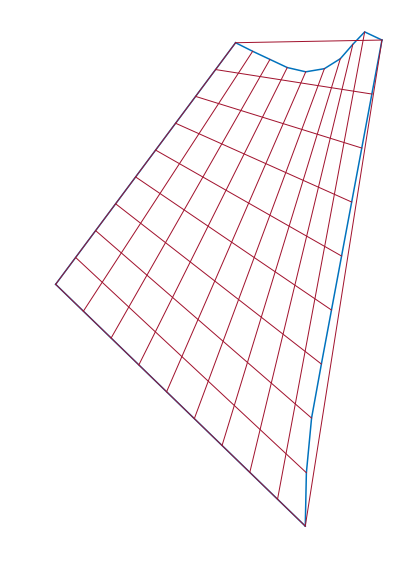

In [44]:
#- Plot it up
plt.figure(figsize=(20,10))
plt.hold = True
for i in range(numSides):
    plt.hold = True
    printBndryArray(spCoordSegList[i].x, spList[i](spCoordSegList[i].x))

printBndryCoord(vertLineArrayTrs1, 1)
printBndryCoord(horizLineArrayTrs1, 1)

`1704.19.May.20`

It's obvious from the plot above that the problems arise when there is any curvature in the boundary.
If it were just some trapezoidal figure, percentages and averages would work perfectly.
But with boundaries that are curved, we need to account for the curve and arclength percentage somehow.

In [94]:
# Plot what I was doing wrong last time 
line = 1 # Do the first line inside the boundary
vertLineArrayTrs2 = np.recarray([numGridLines,numGridLines], coordinate)
horizLineArrayTrs2 = np.recarray([numGridLines,numGridLines], coordinate)

for i in range(numGridLines):
    for j in range(numGridLines):
        vertLineArrayTrs2[i][j].x = ((spCoordSegList[rgt][i].x - spCoordSegList[lft][i].x)*(j/(numGridLines-1))) + spCoordSegList[lft][i].x  
        vertLineArrayTrs2[i][j].y = ((spCoordSegList[top][j].y - spCoordSegList[btm][j].y)*(i/(numGridLines-1))) + spCoordSegList[btm][j].y
        horizLineArrayTrs2[i][j].x = ((spCoordSegList[rgt][j].x - spCoordSegList[lft][j].x)*(i/(numGridLines-1))) + spCoordSegList[lft][j].x  
        horizLineArrayTrs2[i][j].y = ((spCoordSegList[top][i].y - spCoordSegList[btm][i].y)*(j/(numGridLines-1))) + spCoordSegList[btm][i].y

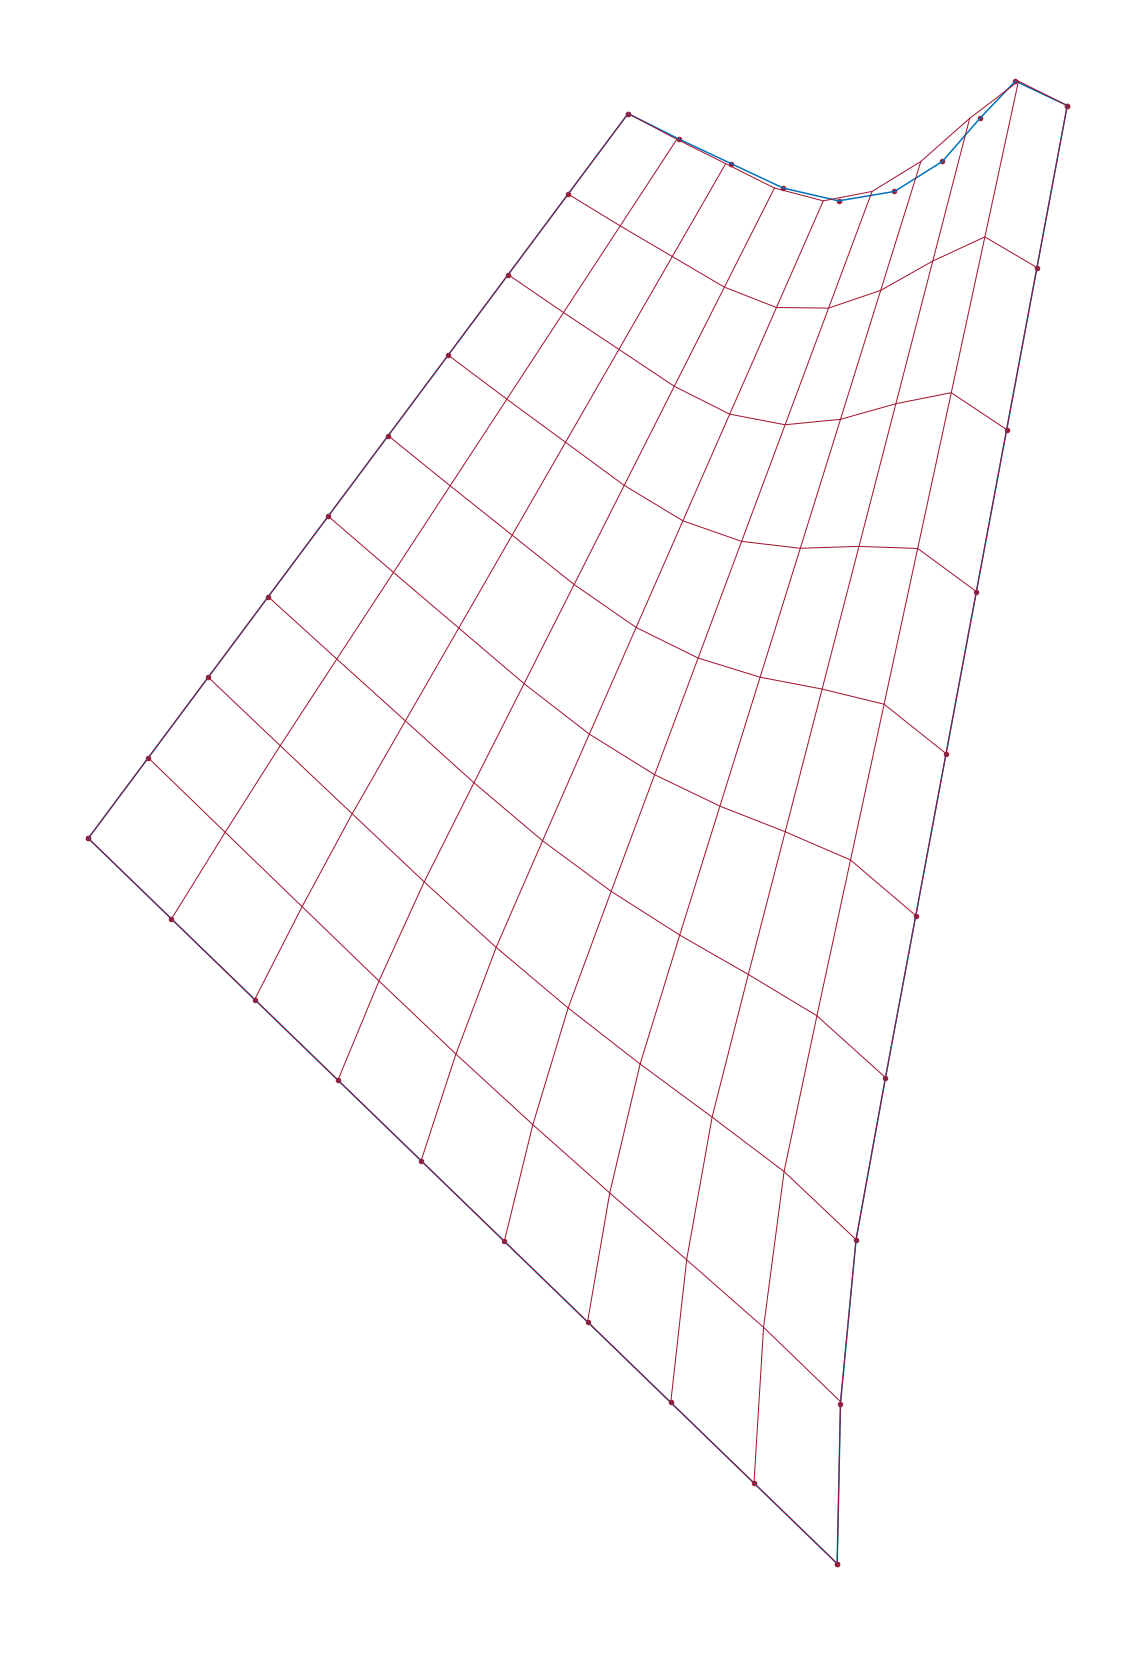

In [100]:
#- Plot it up
plt.figure(figsize=(40,30))
plt.hold = True
for i in range(numSides):
    plt.hold = True
    printBndryArray(spCoordSegList[i].x, spList[i](spCoordSegList[i].x))

printBndryCoord(vertLineArrayTrs2, 1)
printBndryCoord(horizLineArrayTrs2, 1)
printTurbines(spCoordSegList, turbRadius=20)

`1745.19.May.20`

As you can see above, like last time, there is a poriton at the top where things are incorrect (blue boundary is the limit) - this is due to only using two boundaries for each point instead of four.
When I use just the sides to calculate the curve of the top boundary, it doesn't match the arclength of the curve, and is mismatched to the correct tracking.

**Horizontal Lines**

Currently, the horizontal lines use the x-coords from the lft and rgt splines, and the y-coords from the top and btm splines.
It *should*, once it gets to the top, use only the top spline for all x- and y-values, when it's in the center, use averages of the lft and rgt, and then at the btm use just the btm. 
When it [unfinished]

`1800.19.May.20`

I've got to put this away for now, I'll come back to it tomorrow